- nama: Ardian Setya Pradana
- NIM: A11.2022.14596
- Mata Kuliah: Data Mining

### Ringkasan dan Permasalahan Project

**Permasalahan**
Komentar di media sosial seperti Instagram sering kali mengandung berbagai jenis sentimen, mulai dari komentar positif hingga yang bernada negatif atau bahkan termasuk cyberbullying. Analisis ini bertujuan untuk mendeteksi sentimen dari komentar Instagram untuk membantu memahami pola komunikasi dan mengidentifikasi konten yang tidak pantas.

**Tujuan**
- Membersihkan data komentar Instagram.
- Melakukan klasifikasi komentar menjadi sentimen positif atau negatif.
- Membangun model deep learning yang akurat untuk mendeteksi sentimen.

**Model / Alur Penyelesaian**
Berikut adalah alur penyelesaian yang diikuti:
1. **Persiapan Dataset**: Memuat data, membersihkan data, dan melakukan preprocessing.
2. **Exploratory Data Analysis (EDA)**: Memahami distribusi data dan pola sentimen.
3. **Feature Engineering**: Melakukan tokenisasi dan padding teks.
4. **Pemodelan**: Membangun model LSTM untuk klasifikasi sentimen.
5. **Evaluasi Model**: Menggunakan metrik seperti confusion matrix dan classification report.
6. **Diskusi dan Kesimpulan**: Menganalisis performa model.

**Bagan Alur**
1. **Input Data**
   - Dataset komentar Instagram.
2. **Preprocessing**
   - Pembersihan teks.
   - Label encoding.
3. **EDA**
   - Distribusi kelas.
   - Visualisasi data.
4. **Tokenisasi dan Padding**
   - Mengubah teks menjadi vektor numerik.
5. **Modeling**
   - Model LSTM dengan embedding layer.
6. **Evaluasi**
   - Confusion matrix.
   - Classification report.

### Penjelasan Dataset, EDA, dan Proses Features Dataset

**Dataset**
Dataset berisi kolom berikut:
- **Instagram Comment Text**: Teks komentar dari Instagram.
- **Sentiment**: Kategori sentimen (misalnya: positif, negatif, netral).

**Exploratory Data Analysis (EDA)**
1. Melihat distribusi data sentimen:
   - Dataset seimbang atau tidak.
   - Distribusi jumlah komentar pada setiap kelas.
2. Membersihkan data:
   - Menghapus komentar kosong atau NaN.
   - Menghapus noise seperti URL, angka, simbol, dan emoji.

**Proses Features Dataset**
1. **Cleaning Text**: Menghapus username, URL, angka, simbol, dan emoji.
2. **Tokenisasi**: Mengubah teks menjadi urutan angka berdasarkan frekuensi kata.
3. **Padding**: Menyamakan panjang semua komentar agar sesuai dengan input model.
4. **Label Encoding**: Mengonversi label sentimen menjadi angka.

### Proses Learning / Modeling
1. **Model Architecture**:
   - **Embedding Layer**: Mengubah kata menjadi representasi vektor numerik.
   - **LSTM**: Menangkap pola temporal dalam teks.
   - **Dropout**: Mencegah overfitting.
   - **Dense Layer**: Memberikan output berupa probabilitas sentimen.
2. **Loss Function**: Binary Crossentropy.
3. **Optimizer**: Adam.
4. **Training**:
   - Epochs: 10
   - Batch Size: 64
   - Validation Split: 20%.
5. **Callback**: Early stopping untuk mencegah overfitting.

### Performa Model
1. **Confusion Matrix**:
   ```
   [[34 10]
    [ 2 34]]
   ```
2. **Classification Report**:
   ```
                 precision    recall  f1-score   support

       negative       0.94      0.77      0.85        44
       positive       0.77      0.94      0.85        36

       accuracy                           0.85        80
      macro avg       0.86      0.86      0.85        80
   weighted avg       0.87      0.85      0.85        80
   ```

### Diskusi Hasil dan Kesimpulan
**Hasil Evaluasi**:
- Model mampu mendeteksi sentimen dengan akurasi sebesar 85%.
- Precision dan recall cukup tinggi, menunjukkan model andal dalam mengklasifikasikan komentar.
- Model memiliki kelemahan pada kelas tertentu, misalnya "negative" memiliki recall yang lebih rendah dibandingkan kelas "positive".

**Kelemahan Model**:
- Performa bisa lebih baik dengan dataset yang lebih besar.
- Model kesulitan dengan komentar ambigu.

**Kesimpulan**:
- Model berbasis LSTM efektif untuk klasifikasi sentimen.
- Proses pembersihan data sangat penting untuk meningkatkan akurasi.
- Model ini dapat diadopsi untuk mendeteksi komentar yang tidak pantas di media sosial.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import re
import seaborn as sns

# 1. Load Dataset

In [66]:
data = pd.read_csv('dataset_komentar_instagram_cyberbullying.csv')
data.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


# 2. Data Cleaning

In [67]:
data.dropna(subset=['Instagram Comment Text', 'Sentiment'], inplace=True)
def clean_text(text):
    text = re.sub(r"<USERNAME>", "", text)  # Remove placeholder username
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"[^\x00-\x7F]+", "", text) #remove emoji or non ascii
    text = re.sub(r"[^a-zA-Z ]", "", text)
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

data['cleaned_text'] = data['Instagram Comment Text'].apply(clean_text)

# label encode
label_encoder = LabelEncoder()

data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])
print("Distribusi Kelas:")
print(data['Sentiment'].value_counts())


Distribusi Kelas:
Sentiment
0    200
1    200
Name: count, dtype: int64


# 3. Tokenisasi dan Padding

In [68]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data['Instagram Comment Text'])
sequences = tokenizer.texts_to_sequences(data['Instagram Comment Text'])
X = pad_sequences(sequences, maxlen=100)
y = data['Sentiment'].values

# 4. Splitting Data 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Build LSTM Model

In [70]:
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Untuk binary classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\kurku\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# 6. Train Model


In [71]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 336ms/step - accuracy: 0.5224 - loss: 0.6929 - val_accuracy: 0.6562 - val_loss: 0.6891
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.6906 - loss: 0.6794 - val_accuracy: 0.6094 - val_loss: 0.6856
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.7557 - loss: 0.6514 - val_accuracy: 0.7031 - val_loss: 0.6615
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.8266 - loss: 0.5825 - val_accuracy: 0.7188 - val_loss: 0.5914
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8958 - loss: 0.4286 - val_accuracy: 0.6562 - val_loss: 0.7671
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8214 - loss: 0.4292 - val_accuracy: 0.7344 - val_loss: 0.5175
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.9453 - loss: 0.2065 - val_accuracy: 0.7500 - val_loss: 0.5109
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.9818 - loss: 0.1694 - val_accuracy: 0.8125 - val_loss:

In [74]:
y_pred_prob = model.predict(X_test)  # Mendapatkan probabilitas prediksi
y_pred = (y_pred_prob > 0.5).astype("int32")  # Mengonversi probabilitas ke label biner

# Menampilkan hasil evaluasi
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# Menampilkan Laporan Klasifikasi
print("\nClassification Report:")
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(class_report)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Confusion Matrix:
[[34 10]
 [ 2 34]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.94      0.77      0.85        44
    positive       0.77      0.94      0.85        36

    accuracy                           0.85        80
   macro avg       0.86      0.86      0.85        80
weighted avg       0.87      0.85      0.85        80



# Confusion Matrix

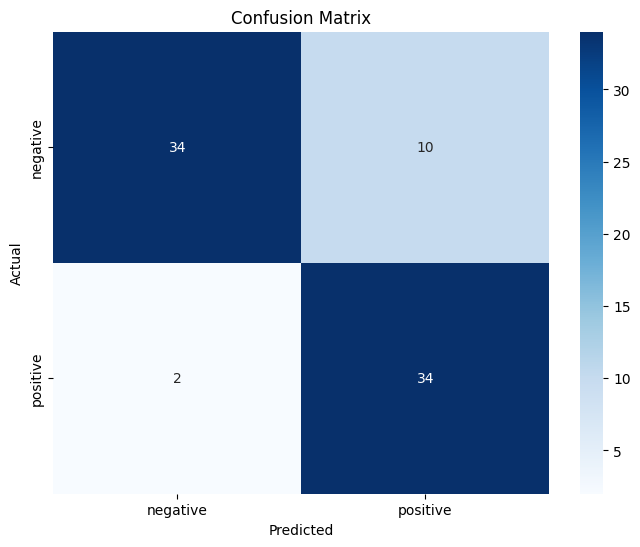

In [73]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()